Comparing Full Versions:
 1. Dirty: search_results.json
 2. Clean: search_results_full_clean.json

검색 성능(Precision@10) 비교
Before (Full Dirty): 0.2118
After  (Full Clean): 0.2114
Improvement        : -0.19%


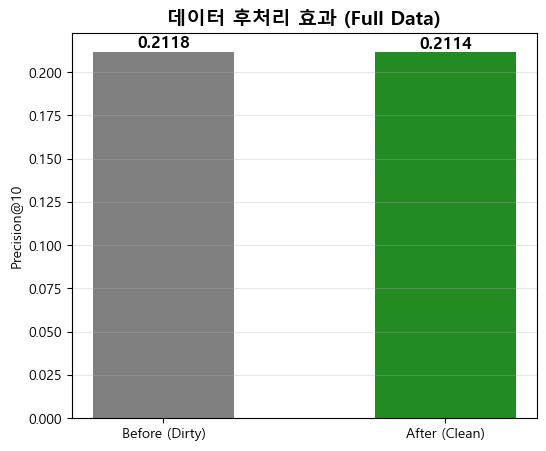

In [4]:
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import sqlite3
from collections import defaultdict
from pathlib import Path

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

PROJECT_ROOT = Path('..').resolve()
RESULTS_DIR = PROJECT_ROOT / 'results'
DATA_DIR = PROJECT_ROOT / 'data'
DB_DIR = PROJECT_ROOT / 'database'

FILE_CLEAN = RESULTS_DIR / 'search_results_full_clean.json'
FILE_DIRTY = RESULTS_DIR / 'search_results.json'
DB_CLEAN = DB_DIR / 'inverted_index_full_clean.db'
DB_DIRTY = DB_DIR / 'inverted_index.db'

print(f"Comparing Full Versions:\n 1. Dirty: {FILE_DIRTY.name}\n 2. Clean: {FILE_CLEAN.name}")

print("\n검색 성능(Precision@10) 비교")

with open(FILE_CLEAN, 'r', encoding='utf-8') as f:
    res_clean = json.load(f)
with open(FILE_DIRTY, 'r', encoding='utf-8') as f:
    res_dirty = json.load(f)

with open(DATA_DIR / 'qrels.pkl', 'rb') as f:
    qrels_list = pickle.load(f)

qrels = defaultdict(set)
for q in qrels_list:
    qrels[q['query-id']].add(q['corpus-id'])

def calculate_p10(search_results):
    scores = []
    for query_res in search_results:
        qid = query_res['query_id']
        if qid not in qrels: continue

        relevant = qrels[qid]
        top10 = [r['doc_id'] for r in query_res['results'][:10]]
        hits = len([d for d in top10 if d in relevant])
        scores.append(hits / 10.0)
    return np.mean(scores)

score_clean = calculate_p10(res_clean)
score_dirty = calculate_p10(res_dirty)

improvement = ((score_clean - score_dirty) / score_dirty) * 100 if score_dirty != 0 else 0

print(f"Before (Full Dirty): {score_dirty:.4f}")
print(f"After  (Full Clean): {score_clean:.4f}")
print(f"Improvement        : {improvement:+.2f}%")

fig, ax = plt.subplots(figsize=(6, 5))
bars = ax.bar(['Before (Dirty)', 'After (Clean)'], [score_dirty, score_clean],
              color=['gray', 'forestgreen'], width=0.5)

ax.set_title('데이터 후처리 효과 (Full Data)', fontsize=14, fontweight='bold')
ax.set_ylabel('Precision@10')
ax.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

In [5]:
print("\nDB 효율성(Efficiency) 비교")

def get_db_stats(db_path):
    if not db_path.exists():
        return 0, 0, 0

    size_mb = os.path.getsize(db_path) / (1024 * 1024)
    conn = sqlite3.connect(str(db_path))
    cursor = conn.cursor()
    cursor.execute("SELECT COUNT(*) FROM inverted_index")
    total_rows = cursor.fetchone()[0]
    cursor.execute("SELECT COUNT(*) FROM term_stats")
    vocab_size = cursor.fetchone()[0]
    conn.close()
    return size_mb, total_rows, vocab_size

clean_stats = get_db_stats(DB_CLEAN)
dirty_stats = get_db_stats(DB_DIRTY)

reduce_size = -(1 - clean_stats[0]/dirty_stats[0])*100 if dirty_stats[0] != 0 else 0
reduce_rows = -(1 - clean_stats[1]/dirty_stats[1])*100 if dirty_stats[1] != 0 else 0
reduce_vocab = -(1 - clean_stats[2]/dirty_stats[2])*100 if dirty_stats[2] != 0 else 0

print(f"{'Metric':<20} | {'Dirty (Before)':<15} | {'Clean (After)':<15} | {'Reduction'}")
print("-" * 65)
print(f"{'File Size (MB)':<20} | {dirty_stats[0]:<15.2f} | {clean_stats[0]:<15.2f} | {reduce_size:.1f}%")
print(f"{'Total Index Rows':<20} | {dirty_stats[1]:<15,} | {clean_stats[1]:<15,} | {reduce_rows:.1f}%")
print(f"{'Vocabulary Size':<20} | {dirty_stats[2]:<15,} | {clean_stats[2]:<15,} | {reduce_vocab:.1f}%")


DB 효율성(Efficiency) 비교
Metric               | Dirty (Before)  | Clean (After)   | Reduction
-----------------------------------------------------------------
File Size (MB)       | 3968.05         | 3692.08         | -7.0%
Total Index Rows     | 24,908,435      | 23,264,390      | -6.6%
Vocabulary Size      | 475,032         | 474,939         | -0.0%
